In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout,Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import time
from wordcloud import WordCloud

In [2]:
#pip install scikeras

In [3]:
data = pd.read_csv('SMSSpamCollection.txt', sep='\t', header=None, names=['Target', 'Text'])

In [4]:
def expand_abbreviations(senti):
    abbreviation_dict = {
        " u ": " you ",
        "dun": "do not",
        "don": "do not",
        "cant": "can not",
        "pl": "please",
        "dont": "do not"
        
}
    for abbr, expanded in abbreviation_dict.items():
        senti = senti.replace(abbr, expanded)
    return senti

In [7]:
stem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
start_time = time.time()
# Preprocess and expand abbreviations for each sentence
sentis = []
for sen in data['Text']:
  senti = re.sub('[^A-Za-z]', ' ', sen)
  senti = senti.lower()
  words = word_tokenize(senti)
  word = [stem.lemmatize(i) for i in words if i not in stop_words]
  senti = ' '.join(word)
  senti = expand_abbreviations(senti)
  sentis.append(senti)

end_time = time.time()
execution_time = end_time - start_time
print(f"Thời gian xử lý sử dụng Lemma Stemmer: {execution_time:.5f} giây")
data['LemmaStemmer_Text_Process'] = sentis
data.head(5)

Thời gian xử lý sử dụng Lemma Stemmer: 1.88111 giây


,Target,Text,LemmaStemmer_Text_Process
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif you oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u do not say early hor you c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [8]:
one_hot_sent = [one_hot(i, 10000) for i in data['LemmaStemmer_Text_Process']]
max_length = max(len(sent) for sent in one_hot_sent)
pad_sequences_result = pad_sequences(one_hot_sent, maxlen=80)
pad_sequences_result

array([[   0,    0,    0, ..., 6311, 7243, 7834],
       [   0,    0,    0, ..., 2431, 3004, 5243],
       [   0,    0,    0, ..., 5692,  458, 5912],
       ...,
       [   0,    0,    0, ..., 8417, 8491, 4907],
       [   0,    0,    0, ..., 2463, 3004, 8895],
       [   0,    0,    0, ..., 7064, 2298, 4466]])

In [9]:
labels = data['Target']
le = LabelEncoder()
encoded_labels = to_categorical(le.fit_transform(labels))
encoded_labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [10]:
X = pad_sequences_result
y = encoded_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
y_test_orig = [np.argmax(i, axis=0) for i in y_test]

In [11]:
X_train_shape = X_train.shape
X_test_shape = X_test.shape
y_train_shape = (len(y_train),)
y_test_shape = (len(y_test),)

X_train_shape, X_test_shape, y_train_shape, y_test_shape

((4457, 80), (1115, 80), (4457,), (1115,))

In [12]:
model=Sequential()
model.add(Embedding(10000,64,input_length=80))
model.add(LSTM(100))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 64)            640000    
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 706202 (2.69 MB)
Trainable params: 706202 (2.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Epoch 1/20
140/140 [==============================] - 8s 45ms/step - loss: 0.2125 - accuracy: 0.9271 - val_loss: 0.0493 - val_accuracy: 0.9857
Epoch 2/20
140/140 [==============================] - 7s 50ms/step - loss: 0.0407 - accuracy: 0.9888 - val_loss: 0.0466 - val_accuracy: 0.9865
Epoch 3/20
140/140 [==============================] - 7s 51ms/step - loss: 0.0164 - accuracy: 0.9962 - val_loss: 0.0476 - val_accuracy: 0.9892
Epoch 4/20
140/140 [==============================] - 7s 52ms/step - loss: 0.0077 - accuracy: 0.9975 - val_loss: 0.0489 - val_accuracy: 0.9874
Epoch 5/20
140/140 [==============================] - 7s 53ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0496 - val_accuracy: 0.9865
Epoch 6/20
140/140 [==============================] - 8s 54ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0510 - val_accuracy: 0.9892
Epoch 7/20
140/140 [==============================] - 7s 53ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.0513 - val_accuracy: 0.9865

In [15]:
y_pred=model.predict(X_test)
y_pred_=[np.argmax(i,axis=0) for i in y_pred]

35/35 [==============================] - 1s 11ms/step


In [16]:
accuracy = accuracy_score(y_test_orig,y_pred_)
print(f'Độ chính xác của mô hình là {accuracy*100:.2f}%')

Độ chính xác của mô hình là 98.57%


In [17]:
print(classification_report(y_test_orig,y_pred_))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.97      0.92      0.94       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



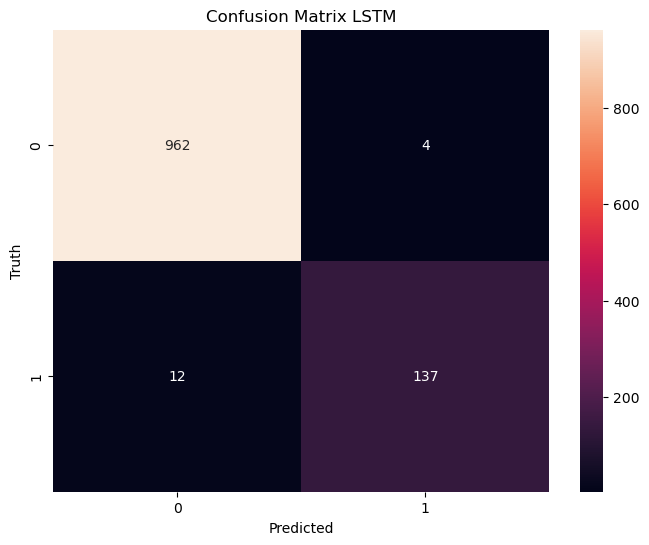

In [18]:
cm_lstm = confusion_matrix(y_test_orig, y_pred_)
labels = list(set(y_test_orig))

plt.figure(figsize=(8,6))
sns.heatmap(cm_lstm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix LSTM')
plt.show()

# Evaluation

In [19]:
# Thêm drop out + thêm learning rate 

In [20]:
from keras.layers import Dropout
from keras.optimizers import Adam

# Tạo mô hình Sequential
model = Sequential()

# Thêm lớp Embedding
model.add(Embedding(10000, 64, input_length=80))

# Thêm lớp LSTM với dropout
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.2))

# Thêm lớp Dropout giữa LSTM và Dense
model.add(Dropout(0.1))

# Thêm lớp Dense với activation là sigmoid
model.add(Dense(2, activation='sigmoid'))

# Tạo optimizer với learning rate
optimizer = Adam(learning_rate=0.001)

# Compile mô hình
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [21]:
model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

Epoch 1/10
140/140 [==============================] - 10s 56ms/step - loss: 0.2709 - accuracy: 0.9112 - val_loss: 0.0586 - val_accuracy: 0.9812
Epoch 2/10
140/140 [==============================] - 9s 63ms/step - loss: 0.0433 - accuracy: 0.9870 - val_loss: 0.0419 - val_accuracy: 0.9892
Epoch 3/10
140/140 [==============================] - 8s 60ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0437 - val_accuracy: 0.9883
Epoch 4/10
140/140 [==============================] - 8s 59ms/step - loss: 0.0100 - accuracy: 0.9980 - val_loss: 0.0475 - val_accuracy: 0.9892
Epoch 5/10
140/140 [==============================] - 8s 59ms/step - loss: 0.0074 - accuracy: 0.9987 - val_loss: 0.0549 - val_accuracy: 0.9821
Epoch 6/10
140/140 [==============================] - 8s 60ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0531 - val_accuracy: 0.9892
Epoch 7/10
140/140 [==============================] - 8s 59ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0565 - val_accuracy: 0.991

In [22]:
y_pred=model.predict(X_test)
y_pred_=[np.argmax(i,axis=0) for i in y_pred]
accuracy = accuracy_score(y_test_orig,y_pred_)
print(f'Độ chính xác của mô hình là {accuracy*100:.2f}%')

35/35 [==============================] - 1s 11ms/step
Độ chính xác của mô hình là 99.10%
